<a href="https://colab.research.google.com/github/ttoygar/MedicalCostAnalysis/blob/main/MedicalCostAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [29]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
import os
from scipy.stats import norm

from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

In [2]:
DATADIR = '/content/drive/MyDrive/DATASCI/MedicalCostAnalysis'

df = pd.read_csv(os.path.join(DATADIR, 'insurance.csv'))

# EDA

In [3]:
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [4]:
df.nunique()

age           47
sex            2
bmi          548
children       6
smoker         2
region         4
charges     1337
dtype: int64

In [5]:
df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


### BMI

(array([ 30., 127., 234., 319., 288., 195.,  96.,  32.,  14.,   3.]),
 array([15.96 , 19.677, 23.394, 27.111, 30.828, 34.545, 38.262, 41.979,
        45.696, 49.413, 53.13 ]),
 <a list of 10 Patch objects>)

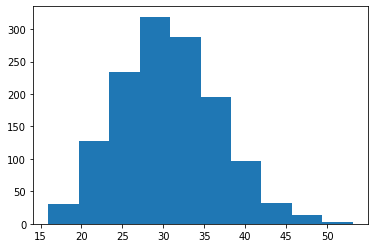

In [6]:
bmi = df["bmi"].values.reshape(-1,1)
plt.hist(bmi)

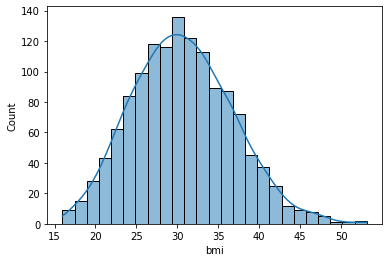

In [7]:
sns.histplot(data=df, x="bmi", kde=True)

## Smoker vs Charges

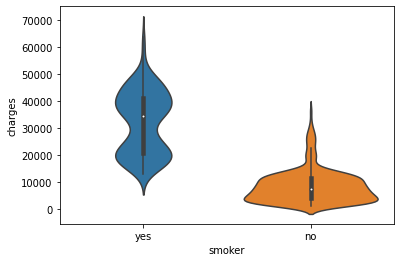

In [8]:
sns.violinplot(data=df, x='smoker', y='charges')

## Smoker vs Region

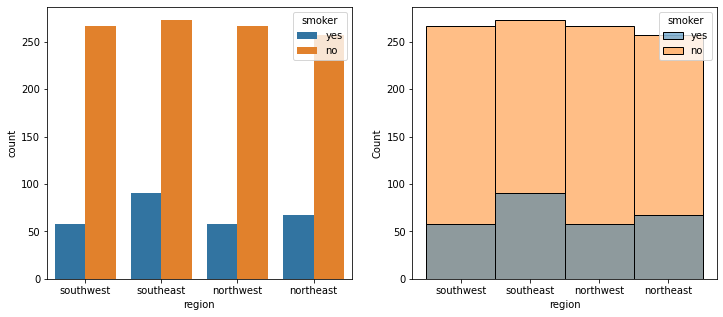

In [9]:
fig, ax = plt.subplots(1,2, figsize=(12,5))
sns.countplot(x='region', data=df, hue='smoker', ax=ax[0])
sns.histplot(x='region', data=df, hue='smoker', ax=ax[1])
fig.show()

## BMI vs Sex

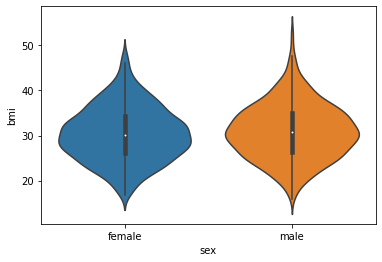

In [10]:
sns.violinplot(data=df, x='sex', y='bmi')

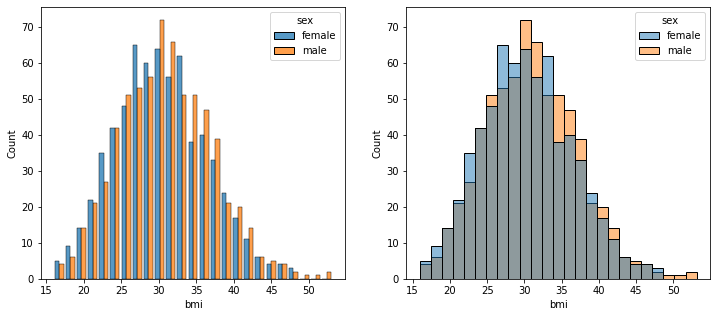

In [11]:
fig, ax = plt.subplots(1,2, figsize=(12,5))
sns.histplot(data=df, hue='sex', x='bmi', multiple="dodge", shrink=.8, ax=ax[0])
sns.histplot(data=df, hue='sex', x='bmi', ax=ax[1])
fig.show()

## Region vs Children

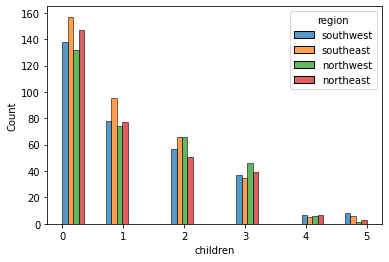

In [12]:
sns.histplot(data=df, hue='region', x='children', multiple="dodge")

## Age vs BMI

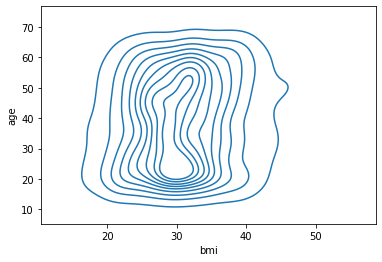

In [13]:
sns.kdeplot(data=df, x='bmi', y='age')

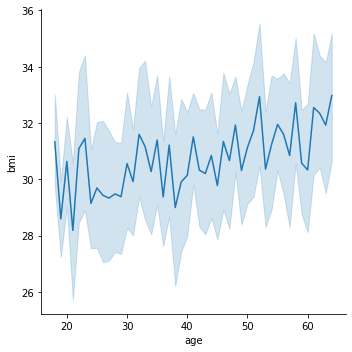

In [14]:
sns.relplot(data=df,x='age',y='bmi',kind='line')

## BMI Outliers

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


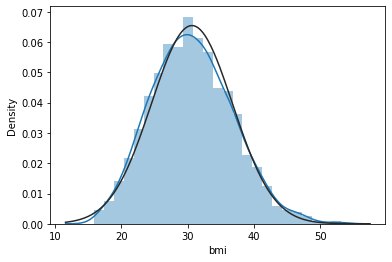

In [36]:
ax = sns.distplot(df.bmi, fit=norm, kde=True)

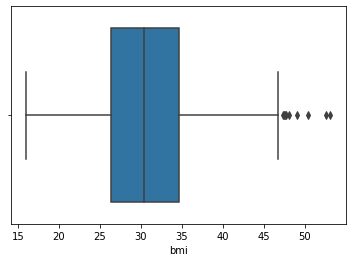

In [16]:
sns.boxplot(data=df, x='bmi')

## BMI vs Charges

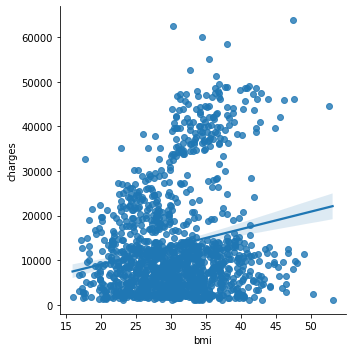

In [17]:
sns.lmplot(data=df, x='bmi',y='charges')

Region vs Smoker vs BMI

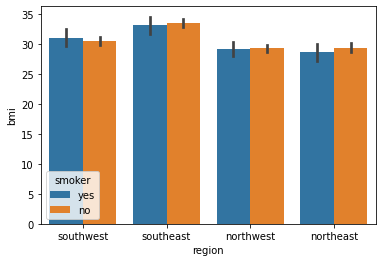

In [18]:
sns.barplot(data=df, y='bmi', x='region', hue='smoker')

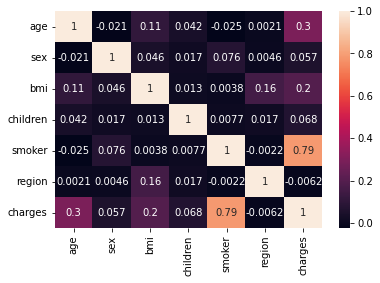

In [19]:
_temp_df = df.copy()
#sex
le = LabelEncoder()
le.fit(_temp_df.sex.drop_duplicates()) 
_temp_df.sex = le.transform(_temp_df.sex)
# smoker or not
le.fit(_temp_df.smoker.drop_duplicates()) 
_temp_df.smoker = le.transform(_temp_df.smoker)
#region
le.fit(_temp_df.region.drop_duplicates()) 
_temp_df.region = le.transform(_temp_df.region)

# Correlation heatmap
sns.heatmap(_temp_df.corr(), annot= True);

● Bu kısımda elinizde olan veriyi model eğitmek için hazır hale getiriniz.

X Kategorik değişkenleri düzenlemek için Label ve One-Hot Encoding tekniklerini
kullanınız.

● Veri setinizi X_train,X_test, y_train, y_test olacak şekilde bölüştürünüz.

● Veri setini normalize ederek ölçekleyiniz

## Separate The Target 

In [20]:
X = df.drop(columns=["charges"])
y = df["charges"]

## Encoding

In [21]:
# Label: smoker, sex
# Onehot: region

X = pd.get_dummies(data = X, columns=["region", "sex", "smoker"], drop_first=True)

X.head()

,age,bmi,children,region_northwest,region_southeast,region_southwest,sex_male,smoker_yes
0,19,27.900,0,0,0,1,0,1
1,18,33.770,1,0,1,0,1,0
2,28,33.000,3,0,1,0,1,0
3,33,22.705,0,1,0,0,1,0
4,32,28.880,0,1,0,0,1,0


## Train Validation Test Split

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=46)

## Normalization

In [23]:
X.head()

,age,bmi,children,region_northwest,region_southeast,region_southwest,sex_male,smoker_yes
0,19,27.900,0,0,0,1,0,1
1,18,33.770,1,0,1,0,1,0
2,28,33.000,3,0,1,0,1,0
3,33,22.705,0,1,0,0,1,0
4,32,28.880,0,1,0,0,1,0


In [24]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [25]:
print(np.mean(X), np.std(X), sep="\n")
print("-"*20)
print(np.mean(X_train_scaled), np.std(X_train_scaled), sep="\n")

age                 39.207025
bmi                 30.663397
children             1.094918
region_northwest     0.242900
region_southeast     0.272048
region_southwest     0.242900
sex_male             0.505232
smoker_yes           0.204783
dtype: float64
age                 14.044709
bmi                  6.095908
children             1.205042
region_northwest     0.428835
region_southeast     0.445014
region_southwest     0.428835
sex_male             0.499973
smoker_yes           0.403543
dtype: float64
--------------------
-9.836368479856527e-17
0.9999999999999999


## Model Selection

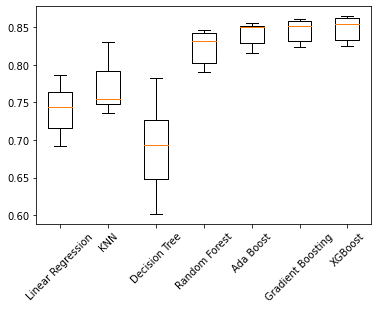

In [26]:
models = {
    'Linear Regression': LinearRegression(),
    'KNN': KNeighborsRegressor(),
    'Decision Tree': DecisionTreeRegressor(),
    'Random Forest': RandomForestRegressor(),
    'Ada Boost': AdaBoostRegressor(n_estimators=50, learning_rate =.01),
    'Gradient Boosting': GradientBoostingRegressor(),
    'XGBoost': XGBRegressor(objective ='reg:linear', verbosity = 0,),
}

results = []

for model in models.values():
    kf = KFold(n_splits=6, random_state=46, shuffle=True)
    cv_results = cross_val_score(model, X_train_scaled, y_train, cv=kf)
    results.append(cv_results)

plt.boxplot(x=results, labels=models.keys())
plt.xticks(rotation=45)
plt.show()

## Hyperparameter Optimization

In [27]:
xgb = XGBRegressor()

params = {
        'eta': [.03, .07, 0.1], # learning_rate,
        'min_child_weight': [.1, .5, 1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [2, 3, 4, 5, 6,]
}


cv = GridSearchCV(
    xgb,
    params,
    cv = 5,
    n_jobs = -1
)

cv.fit(X_train, y_train)

print(cv.best_score_)
print(cv.best_params_)

[14:49:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
0.8474281181047383
{'colsample_bytree': 1.0, 'eta': 0.03, 'gamma': 0.5, 'max_depth': 3, 'min_child_weight': 10, 'subsample': 1.0}


## Model Evaluation

In [30]:
# Training the model
xgb_model = XGBRegressor(
    objective ='reg:squarederror', 
    learning_rate=0.03, 
    max_depth = 3, 
    min_child_weight = 10, 
    colsample_bytree=1.0, 
    subsample=1.0, 
    gamma=0.5
)
xgb_model.fit(X_train, y_train)

# Prediction
predictions = xgb_model.predict(X_test)

In [31]:
# Comparison of actual and prediction
comparison = pd.DataFrame({"Actual Values": y_test,"Predictions": predictions})
comparison.head()

,Actual Values,Predictions
141,3490.5491,5460.790527
1065,7045.4990,7039.844727
467,12643.3778,13318.872070
557,3935.1799,5337.321289
166,4830.6300,5853.561523


In [33]:
# Calculation of Root Mean Squared Error, Mean Absolute Error and r2_score
rmse = np.sqrt(mean_squared_error(y_test, predictions))
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

In [34]:
scores = pd.DataFrame(data={"Mean Squared Error": [rmse], "Mean Absolute Error": [mae], "R2 Score": [r2]})
scores

,Mean Squared Error,Mean Absolute Error,R2 Score
0,3964.34385,2089.988495,0.892454
